In [1]:
import matplotlib.pyplot as plt   
import numpy as np   
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

from keras.layers.core import Dense,Activation,Dropout
from keras.layers import LSTM 
from keras.models import Sequential

2023-05-16 20:40:50.571213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 20:40:50.701677: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
data = pd.read_csv('stock1.csv')
data = data[['Open','High','Low','Volume','Close']]
data.head()

,Open,High,Low,Volume,Close
0,7832.580078,7946.229980,7826.669922,2168720000,7898.049805
1,7829.029785,7918.709961,7810.350098,2176380000,7816.279785
2,7714.060059,7747.270020,7678.350098,2130700000,7702.379883
3,7765.569824,7804.439941,7752.919922,2000130000,7785.720215
4,7749.799805,7786.330078,7738.350098,1884660000,7750.839844


In [3]:
sequence_length = 21
n_features = len(data.columns)
val_ratio = 0.1
n_epochs = 300
batch_size = 512

In [4]:
data = data.iloc[:,:].values
data_processed = []
for index in range(len(data)-sequence_length):
    data_processed.append(data[index:index+sequence_length])
data_processed = np.array(data_processed)

In [5]:
val_split  = round((1-val_ratio)*data_processed.shape[0])
train = data_processed[:int(val_split),:]
val = data_processed[int(val_split):,:]
print('Training data:{}'.format(train.shape))
print('vali data:{}'.format(val.shape))

Training data:(662, 21, 5)
vali data:(73, 21, 5)


In [6]:
train_samples, train_nx, train_ny = train.shape
val_samples, val_nx, val_ny = val.shape

train = train.reshape((train_samples, train_nx * train_ny))
val = val.reshape((val_samples, val_nx * val_ny))

preprocessor = MinMaxScaler().fit(train)
train = preprocessor.transform(train)
val = preprocessor.transform(val)

train = train.reshape((train_samples, train_nx, train_ny))
val = val.reshape((val_samples, val_nx, val_ny))

In [7]:
X_train = train[:, : -1]
y_train = train[:, -1][: ,-1]
X_val = val[:, : -1]
y_val = val[:, -1][ : ,-1]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], n_features))

In [8]:
model = Sequential([
    LSTM(input_shape=(X_train.shape[1:]),units = 128,return_sequences=True),
    Dropout(0.5),
    LSTM(128,return_sequences=False),
    Dropout(0.25),
    Dense(units=1),
    Activation('linear')
    
])
model.compile(loss="mse",optimizer="adam")
history = model.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs=n_epochs,
    verbose=2
)

2023-05-16 20:40:52.257617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/300
2/2 - 4s - loss: 0.2844 - 4s/epoch - 2s/step
Epoch 2/300
2/2 - 0s - loss: 0.0225 - 227ms/epoch - 114ms/step
Epoch 3/300
2/2 - 0s - loss: 0.0562 - 224ms/epoch - 112ms/step
Epoch 4/300
2/2 - 0s - loss: 0.0077 - 235ms/epoch - 118ms/step
Epoch 5/300
2/2 - 0s - loss: 0.0229 - 233ms/epoch - 116ms/step
Epoch 6/300
2/2 - 0s - loss: 0.0282 - 226ms/epoch - 113ms/step
Epoch 7/300
2/2 - 0s - loss: 0.0164 - 223ms/epoch - 111ms/step
Epoch 8/300
2/2 - 0s - loss: 0.0068 - 255ms/epoch - 127ms/step
Epoch 9/300
2/2 - 0s - loss: 0.0097 - 237ms/epoch - 119ms/step
Epoch 10/300
2/2 - 0s - loss: 0.0129 - 226ms/epoch - 113ms/step
Epoch 11/300
2/2 - 0s - loss: 0.0084 - 222ms/epoch - 111ms/step
Epoch 12/300
2/2 - 0s - loss: 0.0053 - 224ms/epoch - 112ms/step
Epoch 13/300
2/2 - 0s - loss: 0.0066 - 224ms/epoch - 112ms/step
Epoch 14/300
2/2 - 0s - loss: 0.0076 - 228ms/epoch - 114ms/step
Epoch 15/300
2/2 - 0s - loss: 0.0072 - 223ms/epoch - 112ms/step
Epoch 16/300
2/2 - 0s - loss: 0.0053 - 225ms/epoch - 11

In [9]:
preds_val = model.predict(X_val)
diff = []
for i in range(len(y_val)):
    pred = preds_val[i][0]
    diff.append(y_val[i] - pred)

3/3 [==============================] - 1s 9ms/step


In [10]:
real_min = preprocessor.data_min_[104]
real_max = preprocessor.data_max_[104]
print(preprocessor.data_min_[104])
print(preprocessor.data_max_[104])

preds_real = preds_val * (real_max - real_min) + real_min
y_val_real = y_val * (real_max - real_min) + real_min

6860.669922
16057.44043


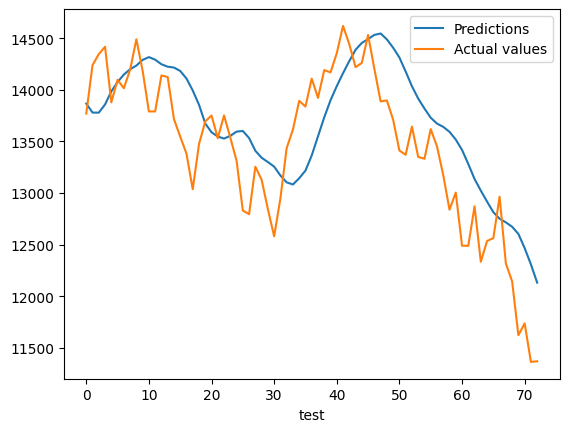

In [11]:
plt.plot(preds_real, label='Predictions')
plt.plot(y_val_real, label='Actual values')
plt.xlabel('test')
plt.legend(loc=0)
plt.show()